In [49]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import IQPAnsatz, AtomicType

n, s = Ty('n'), Ty('s')
# nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("ja_ginza")
# nlp = spacy.load("en_core_web_trf")
# モデルの大きさによって解析精度に差あり

In [2]:
sentence = '熟練した男はソースを準備します。'
doc = nlp(sentence)
displacy.serve(doc, style='dep', port=5001)

for token in doc:
    print(token.text+'<-'+token.head.text,token.dep_)

# 文頭を大文字、文末にピリオド をちゃんとやると正確になりやすいかも

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\spacy\displacy\__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...

Shutting down server on port 5001.
熟練<-男 acl
し<-熟練 aux
た<-熟練 aux
男<-準備 nsubj
は<-男 case
ソース<-準備 obj
を<-ソース case
準備<-準備 ROOT
し<-準備 aux
ます<-準備 aux
。<-準備 punct


In [3]:
# 型の割り当て
def assign_types(doc):
    pregroup_types = {}
    doc = nlp(sentence)
    # トークン化
    tokens = [token.text for token in doc]
    # 依存関係をまとめる
    # dependencies = [(token.text, token.head.text) for token in doc if token.text != "."]
    dependencies = []
    
    for token in doc:
        if token.dep_ == 'ROOT':
            pregroup_types[token.text] = s
            dependencies.append((token.text, token.head.text))
        elif token.pos_ in ['NOUN','PRON']:
            pregroup_types[token.text] = n
            if token.head.dep_ == 'ROOT':
                dependencies.append((token.text, token.head.text))
    print(dependencies)
    # 依存関係による型の割り当て（ペアと語順）
    
    for dep in dependencies:
        idx1 = tokens.index(dep[0])
        idx2 = tokens.index(dep[1])
        if idx1 < idx2:
            pregroup_types[token.head.text] = n.r @ pregroup_types[token.head.text]
        elif idx1 > idx2:
            pregroup_types[token.head.text] = pregroup_types[token.head.text] @ n.l
        else:
            pass

    return pregroup_types

In [4]:
sentence = '熟練した男は料理を作る。'
types = assign_types(sentence)
print(types)

[('男', '作る'), ('料理', '作る'), ('作る', '作る')]
{'男': Ty(n), '料理': Ty(n), '作る': Ty(n).r @ Ty(n).r @ Ty(s)}


In [5]:
t = types['作る']
print(t)

n.r @ n.r @ s


In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

# 日本語フォントを設定
font_path = "C:\\Windows\\Fonts\\meiryo.ttc" 
jp_font = fm.FontProperties(fname=font_path) 
# matplotlibにフォントを設定
rcParams['font.family'] = jp_font.get_name()

# diagram作成
def create_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # カップ構造を作る
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

[('男', '作る'), ('料理', '作る'), ('作る', '作る')]
熟練した男は料理を作る。


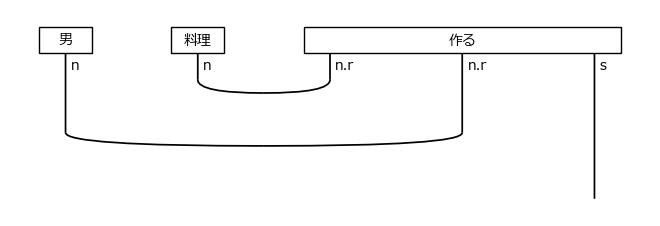

In [7]:
sentence = '熟練した男は料理を作る。'
diagram = create_diagram(sentence)
print(sentence)
draw(diagram)

In [40]:
def rotate_type(sentence: str, target_word: str, k: int = 1):
    
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)
    target_types = []
    rotated = []
    rotated_type = Ty()
    
    org_type = pregroup_types[target_word]
    target_types = list(org_type)
    
    def swap_with_prev(d, key):
        items = list(d.items())
        keys = [k for k, _ in items]
        i = keys.index(key)
        if i == 0:
            return d  # 先頭なら入れ替え不可
        items[i - 1], items[i] = items[i], items[i - 1]
        return dict(items)
    
    def swap_with_next(d, key):
        items = list(d.items())
        keys = [k for k, _ in items]
        i = keys.index(key)
        if i + 1 >= len(items):
            return d  # 最後尾なら無理
        items[i], items[i + 1] = items[i + 1], items[i]
        return dict(items)
    
    k = k % len(target_types)  # リスト長で割った余りだけ回す
    rotated = target_types[k:] + target_types[:k]
    
    rotated_types = target_types[:k]
    slided_types = target_types[k:]
    if k <= target_types.index(s):
        for i in range(len(rotated_types)):
            # 右随伴なら
            if  rotated_types[i] == n.r:
                pregroup_types = swap_with_prev(pregroup_types,target_word)
                rotated_types[i] = n.l 
                
            else:
                pass

    else:
        for i in range(len(slided_types)):       
            if  slided_types[i] == n.r:
                pregroup_types = swap_with_next(pregroup_types,target_word)
                slided_types[i] = n.l 
            else:
                pass
    rotated = slided_types + rotated_types
    
    for i in rotated:
        rotated_type @= i
    rotated_type
    
    pregroup_types[target_word] = rotated_type
    
    return pregroup_types

In [42]:
# diagram作成
def create_rotated_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = rotate_type(doc, target_word)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # カップ構造を作る
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

In [41]:
sentence = '熟練した男は料理を作る。'
target_word = '作る'
test = rotate_type(sentence, target_word)
print(test)


[('男', '作る'), ('料理', '作る'), ('作る', '作る')]
{'男': Ty(n), '作る': Ty(n).r @ Ty(s) @ Ty(n).l, '料理': Ty(n)}


[('男', '作る'), ('料理', '作る'), ('作る', '作る')]


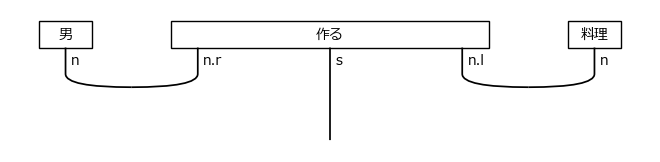

In [43]:
rotated_diagram = create_rotated_diagram(sentence)
draw(rotated_diagram)

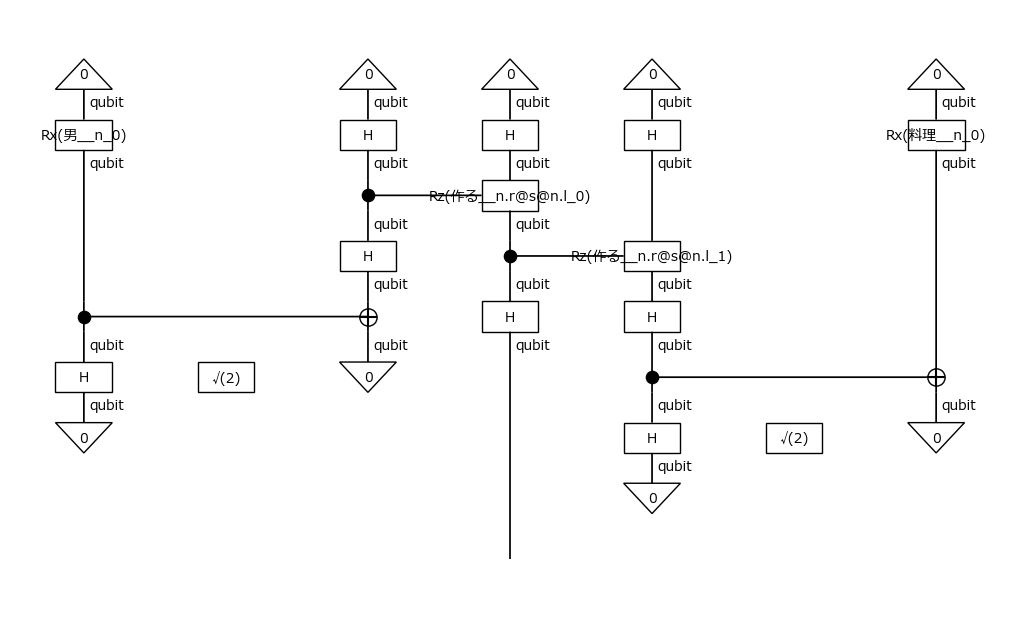

In [50]:
# 量子回路設計（IQPAnsatz）
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=1)
circuits = ansatz(rotated_diagram)


circuits.draw(figsize=(10, 6))